In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# reading data file

df = pd.read_csv("glass.dat", delimiter=r"\s+", usecols=["RI", "Al"])

df_sorted = df.sort_values(by='Al')
X = df_sorted['Al'].to_numpy()
Y = df_sorted['RI'].to_numpy()

In [3]:
def gaussian_kernel(u):
    """
    Gaussian kernel function.
    """
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

def epanechnikov_kernel(u):
    """
    Epanechnikov kernel function.
    """
    return (3 / 4) * np.maximum(1 - pow(u, 2), 0) # Returns 0 for |u| > 1

In [4]:
def nadaraya_watson(x, y, x_query, h, kernel):
    '''
    Compute Nadaraya Watson kernel for give x, y, x_query and h
    '''
    weights = kernel((x_query - x) / h)
    numerator = np.sum(weights * y)
    denominator = np.sum(weights)
    # print(weights, denominator)

    if denominator == np.zeros(1):
        return np.nan
    
    return numerator / denominator

In [5]:
def cross_validation_bandwidth(shuffled_X, shuffled_Y, kernel, h_values, k=10):
    """Function used to select the optimal bandwidth using cross-validation.

    Returns a list of mean squared errors for each bandwidth in h_values.

    k-fold cross-validation is used"""
    
    subsample_size = shuffled_X.size//k

    indices = np.arange(0, df["Al"].size)

    mse_avg = np.zeros(h_values.size, dtype=float)

    for index in range(h_values.size):
        h = h_values[index]
        mse_sum = 0
        for i in range(k):
            val_indices = indices[subsample_size*i : subsample_size*(i+1)]
            # print(val_indices.size)
            train_indices = np.setdiff1d(indices, val_indices)
            # print(train_indices, val_indices)
            X_train = shuffled_X[train_indices]
            # X_train = []
            Y_train = shuffled_Y[train_indices]
            # Y_train = []
            X_val = shuffled_X[val_indices]
            Y_val = shuffled_Y[val_indices]

            y_pred = np.array([nadaraya_watson(X_train, Y_train, xq, h, kernel) for xq in X_val])
            mse = np.mean((Y_val - y_pred) ** 2)
            mse_sum += mse
            # print(f"Bandwidth: {h}, Fold: {i}, MSE: {mse}")

        mse_avg[index] = mse_sum / k
        if np.isnan(mse_avg[index]):
            mse_avg[index] = np.inf

    return mse_avg
 


In [6]:
# Define a range of bandwidth values
h_values = np.linspace(0.01, 2, 50)

# shuffling the dataset
shuffled_df = df.sample(frac=1)
shuffled_X = shuffled_df["Al"].to_numpy()
shuffled_Y = shuffled_df["RI"].to_numpy()

# Cross-validation to find the best bandwidth for Gaussian kernel
errors_gaussian = cross_validation_bandwidth(shuffled_X, shuffled_Y, gaussian_kernel, h_values)
best_h_gaussian = h_values[np.argmin(errors_gaussian)]
print("Minimum cross-validation error for Gaussian kernel", np.min(errors_gaussian))
print("Optimal bandwidth for Gaussian kernel: ", best_h_gaussian)

# Cross-validation to find the best bandwidth for Epanechnikov kernel
errors_epanechnikov = cross_validation_bandwidth(shuffled_X, shuffled_Y, epanechnikov_kernel, h_values)
best_h_epanechnikov = h_values[np.argmin(errors_epanechnikov)]
print("Minimum cross-validation error for Epanechnikov kernel", np.min(errors_epanechnikov))
print("Optimal bandwidth for Epanechnikov kernel: ", best_h_epanechnikov)

Minimum cross-validation error for Gaussian kernel 6.886513922520301
Optimal bandwidth for Gaussian kernel:  0.13183673469387755
Minimum cross-validation error for Epanechnikov kernel 7.250571466502755
Optimal bandwidth for Epanechnikov kernel:  0.49734693877551023


In [7]:
# Define points to query
x_query = X

# Estimate using the best bandwidths found
# These values are hardcoded to prevent variation in results due to shuffling of data
best_h_gaussian = 0.13183673469387755
best_h_epanechnikov = 0.49734693877551023

y_est_gaussian = [nadaraya_watson(X, Y, xq, best_h_gaussian, gaussian_kernel) for xq in x_query]
y_est_gaussian_under = [nadaraya_watson(X, Y, xq, best_h_gaussian/4, gaussian_kernel) for xq in x_query]
y_est_gaussian_over = [nadaraya_watson(X, Y, xq, best_h_gaussian*4, gaussian_kernel) for xq in x_query]

y_est_epanechnikov = [nadaraya_watson(X, Y, xq, best_h_epanechnikov, epanechnikov_kernel) for xq in x_query]
y_est_epanechnikov_under = [nadaraya_watson(X, Y, xq, best_h_epanechnikov/4, epanechnikov_kernel) for xq in x_query]
y_est_epanechnikov_over = [nadaraya_watson(X, Y, xq, best_h_epanechnikov*4, epanechnikov_kernel) for xq in x_query]

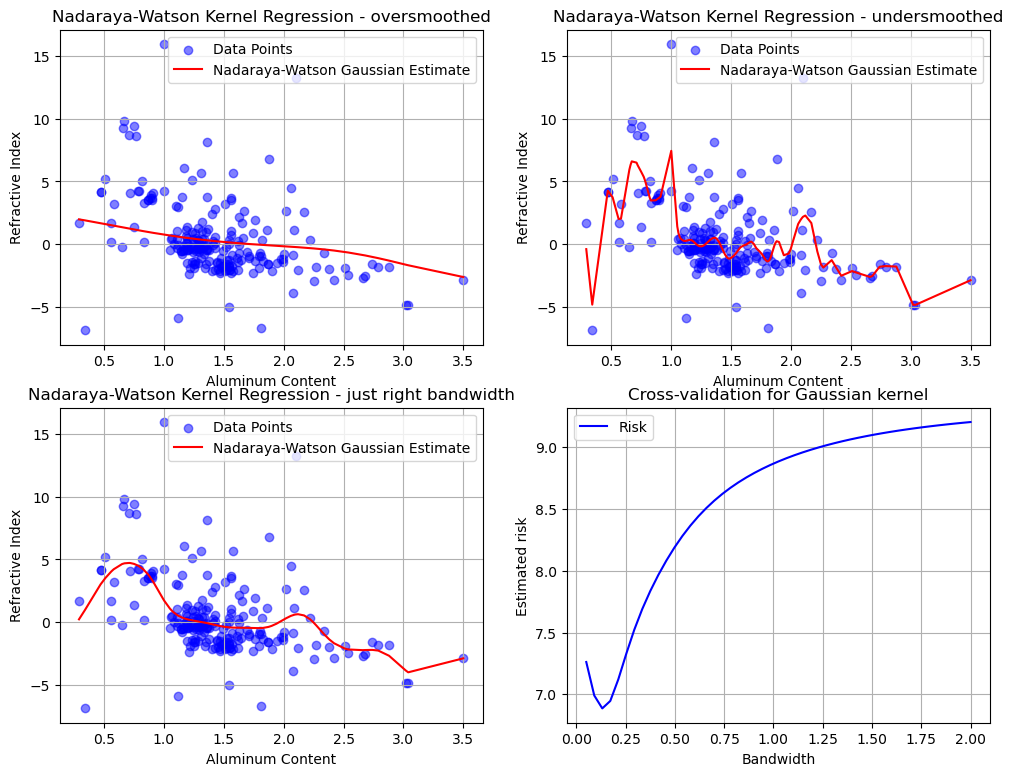

In [8]:
# Plotting results - Gaussian kernel
plt.figure(figsize=(12, 9))
plt.subplot(2, 2, 1)
plt.scatter(X, Y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_query, y_est_gaussian_over, color='red', label='Nadaraya-Watson Gaussian Estimate')
plt.title('Nadaraya-Watson Kernel Regression - oversmoothed')
plt.xlabel('Aluminum Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.scatter(X, Y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_query, y_est_gaussian_under, color='red', label='Nadaraya-Watson Gaussian Estimate')
plt.title('Nadaraya-Watson Kernel Regression - undersmoothed')
plt.xlabel('Aluminum Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.scatter(X, Y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_query, y_est_gaussian, color='red', label='Nadaraya-Watson Gaussian Estimate')
plt.title('Nadaraya-Watson Kernel Regression - just right bandwidth')
plt.xlabel('Aluminum Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(h_values, errors_gaussian, color='blue', label='Risk')
plt.title('Cross-validation for Gaussian kernel')
plt.xlabel('Bandwidth')
plt.ylabel('Estimated risk')
plt.legend()
plt.grid()
# plt.show()
plt.savefig("gaussian_kernel_regression.png")

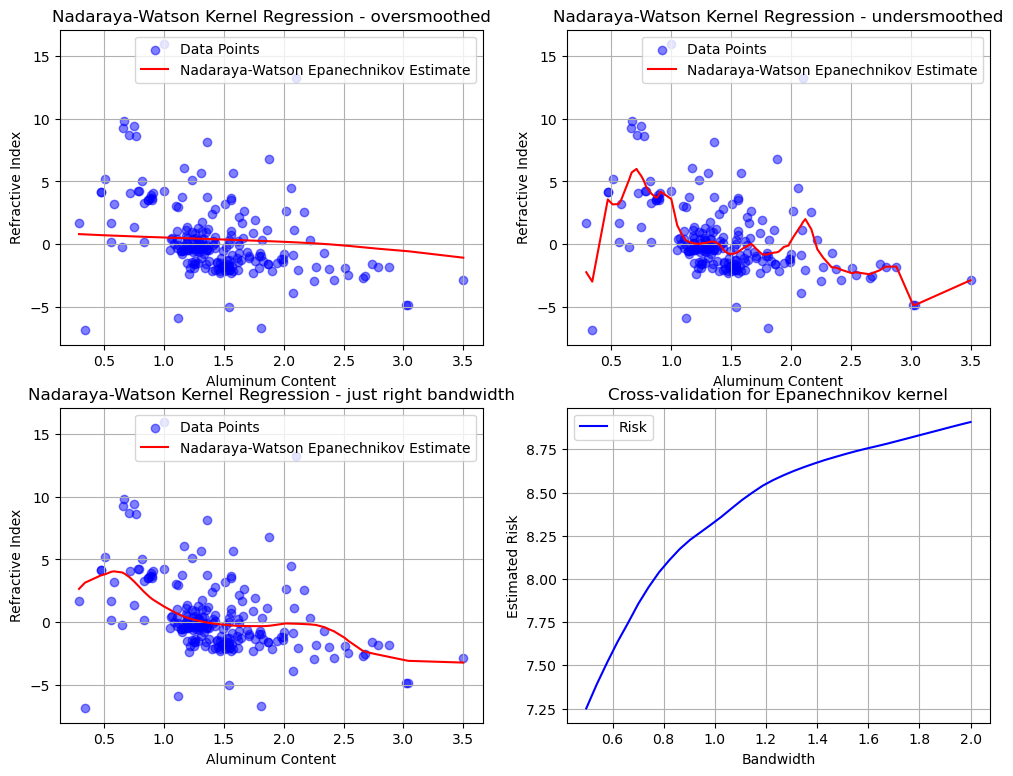

In [9]:
# Plotting results - Epanechnikov kernel
plt.figure(figsize=(12, 9))
plt.subplot(2, 2, 1)
plt.scatter(X, Y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_query, y_est_epanechnikov_over, color='red', label='Nadaraya-Watson Epanechnikov Estimate')
plt.title('Nadaraya-Watson Kernel Regression - oversmoothed')
plt.xlabel('Aluminum Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.scatter(X, Y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_query, y_est_epanechnikov_under, color='red', label='Nadaraya-Watson Epanechnikov Estimate')
plt.title('Nadaraya-Watson Kernel Regression - undersmoothed')
plt.xlabel('Aluminum Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.scatter(X, Y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_query, y_est_epanechnikov, color='red', label='Nadaraya-Watson Epanechnikov Estimate')
plt.title('Nadaraya-Watson Kernel Regression - just right bandwidth')
plt.xlabel('Aluminum Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(h_values, errors_epanechnikov, color='blue', label='Risk')
plt.title('Cross-validation for Epanechnikov kernel')
plt.xlabel('Bandwidth')
plt.ylabel('Estimated Risk')
plt.legend()
plt.grid()
# plt.show()
plt.savefig("epanechnikov_kernel_regression.png")

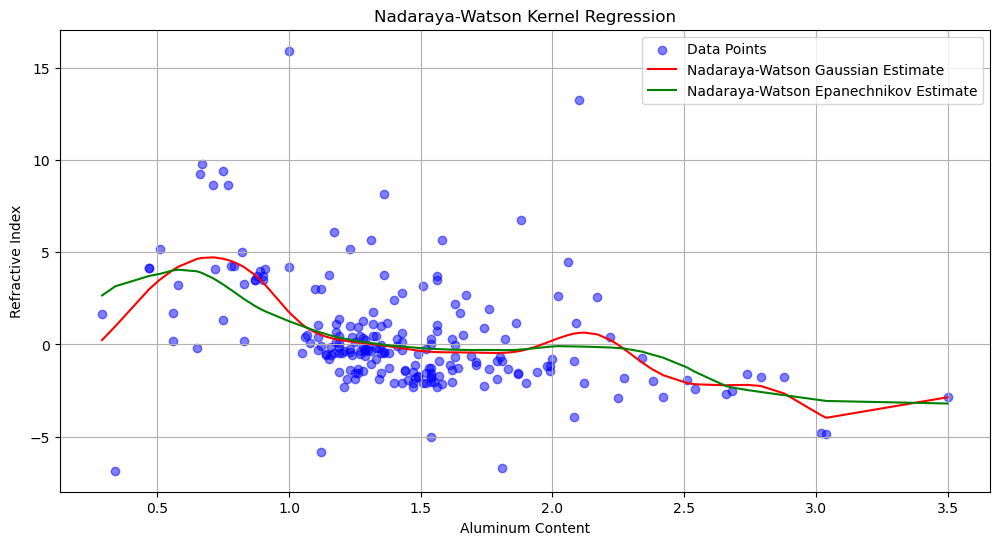

In [10]:
# Overlapped plots
plt.figure(figsize=(12, 6))
plt.scatter(X, Y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_query, y_est_gaussian, color='red', label='Nadaraya-Watson Gaussian Estimate')
plt.plot(x_query, y_est_epanechnikov, color='green', label='Nadaraya-Watson Epanechnikov Estimate')
plt.title('Nadaraya-Watson Kernel Regression')
plt.xlabel('Aluminum Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.grid()
# plt.show()
# plt.savefig("overlapped_kernel_regression.png")